<a href="https://colab.research.google.com/github/Sukhdeep2006/Learning-TensorFlow/blob/main/007_TF_TimeSeries_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Forecasting

In this notebook we will learn about the Time Series Forecasting.



In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
keras = tf.keras

In [ ]:
def plot_series(time, series, format='-', start = 0, end =None, label = None):
  plt.plot(time[start:end], series[start:end], format, label =label)
  plt.xlabel("Time")
  plt.ylabel("Value")
  if label:
    plt.legend(fontsize = 14)
  plt.grid(True)

In [ ]:
def trend(time, slope = 0):
  return time*slope

In [ ]:
def seasonal_pattern(season_time):
  return np.where(season_time < 0.4,
                  np.cos(season_time * 2 * np.pi), 
                  1/np.exp(3* season_time))

In [ ]:
def seasonality(time, period, amplitude =1, phase=0):
  season_time = ((time + phase) % period)/period
  return amplitude * seasonal_pattern(season_time)

In [ ]:
def white_noise(time, noise_level =1, seed = None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level

In [ ]:
def moving_average_forecast_simple(series, window_size):       
  '''this is a traightforward method but super slow way of calculating moving average of the series.'''
  forecast = []
  for time in range(len(series) - window_size):
    forecast.append(series[time:time+window_size].mean())
  return(np.array(forecast))

In [ ]:
def moving_average_forecast(series, window_size):       
  '''This is an efficient way of implementing the moving average of a time series.'''
  mov = np.cumsum(series)
  mov[window_size:] = mov[window_size:] - mov[:-window_size]
  return mov[window_size-1: -1]/window_size

In [ ]:
def moving_average_forecast_mine(series, window_size):       
  '''this is a straightforward method but super slow way of calculating moving average of the series.'''
  forecast = []
  for time in range(window_size, len(series)+1):
    forecast.append(series[time-window_size:time].mean())
  return(np.array(forecast))

In [ ]:
def window_dataset(series, window_size, batch_size = 32, shuffle_buffer = 1000):
  
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size+1,
                 shift =1, 
                 drop_remainder = True)
  ds = ds.flat_map(lambda w: w.batch(window_size +1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[-1]))
  
  return ds.batch(batch_size).prefetch(1)

In [ ]:
def seq2seq_window_dataset(series, window_size, batch_size = 32, shuffle_buffer = 1000):
  
  series = tf.expand_dims(series, axis = -1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size+1,
                 shift =1, 
                 drop_remainder = True)
  ds = ds.flat_map(lambda w: w.batch(window_size +1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[1:]))
  
  return ds.batch(batch_size).prefetch(1)

In [ ]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1 , drop_remainder = True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  return model.predict(ds)


### Lets just create a time series that just trends upwards:

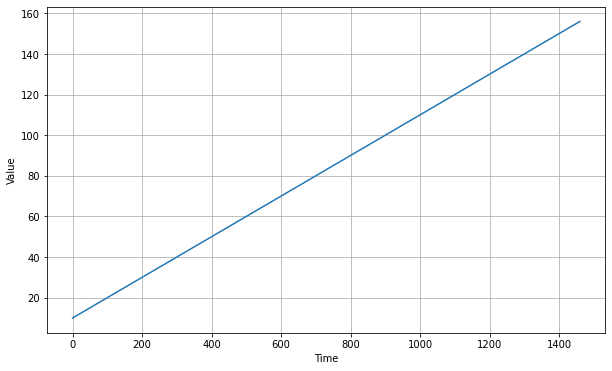

In [ ]:
time = np.arange(4 * 365 +1)
baseline = 10
series = baseline + trend(time, 0.1)
plt.figure(figsize =(10,6))
plot_series(time, series)
plt.show()

In [ ]:
time, series

(array([   0,    1,    2, ..., 1458, 1459, 1460]),
 array([ 10. ,  10.1,  10.2, ..., 155.8, 155.9, 156. ]))

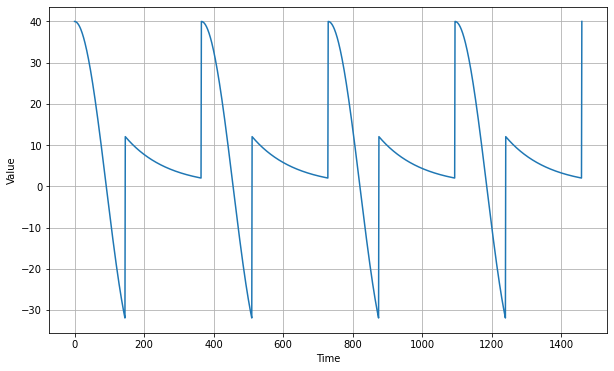

In [ ]:
amplitude = 40
series = seasonality(time, period = 365, amplitude=amplitude)

plt.figure(figsize = (10,6))
plot_series(time, series)
plt.show()

### Now, lets create a time series with boht Trend, Seasonality and some Noise:

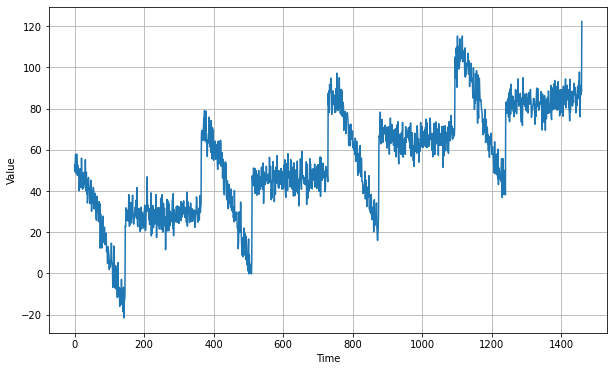

In [ ]:
slope = 0.05
series = baseline + trend(time, slope) + seasonality(time, period = 365, amplitude=amplitude) + white_noise(time, 5, seed = 42)

plt.figure(figsize = (10,6))
plot_series(time, series)
plt.show()


### Lets now split our time series into two periods, one will be the training period and the other will be our validation period. The split will be at time step 1000.



In [ ]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

## Naive Forecast

we will simply forecast the value as previous day's value.

In [ ]:
naive_forecast = series[split_time -1 : -1]

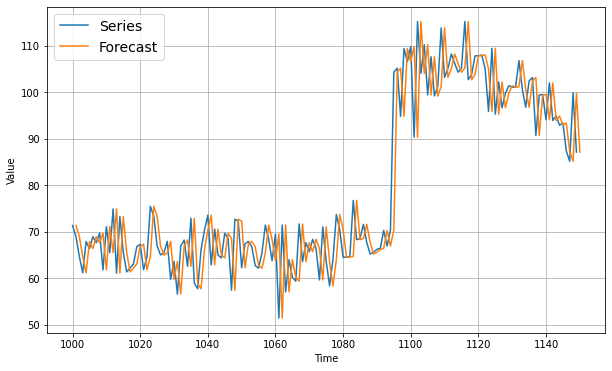

In [ ]:
plt.figure(figsize = (10,6))

#plot_series(time_valid, x_valid, label = "Series")
#plot_series(time_valid, naive_forecast, label = 'Forecast' )

plot_series(time_valid, x_valid, start = 0, end = 150, label = "Series")
plot_series(time_valid, naive_forecast,start = 1, end = 151, label = 'Forecast' )

In [ ]:
errors = naive_forecast - x_valid
abs_errors = np.abs(errors)
mae = abs_errors.mean()
mae
# keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy()

5.9379085153216735

### This is our baseline error, lets try now the moving average.

7.1424185706207854

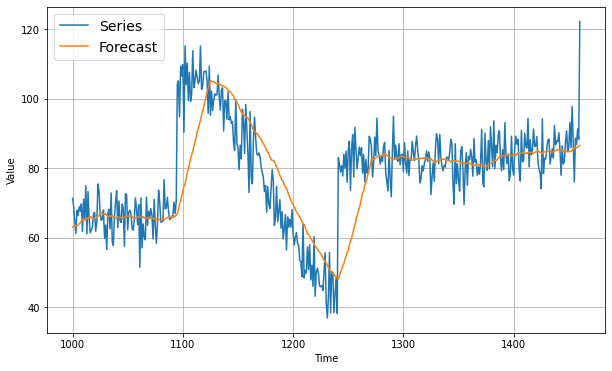

In [ ]:
win_size = 30
moving_avg = moving_average_forecast(series, win_size)[split_time -win_size:]

plt.figure(figsize = (10,6))
plot_series(time_valid, x_valid, label = "Series")
plot_series(time_valid, moving_avg, label = 'Forecast')

keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy()


By looking at the mean absolute error this seems even worse than the naive forecast. This is because the moving average doesnt anticipate the Trend and Seasonality, so in order to fix this,  lets remove them by using differencing. Since the seasonality period is over 365 days, we will subtract the value at time t-365 from the value at time t.

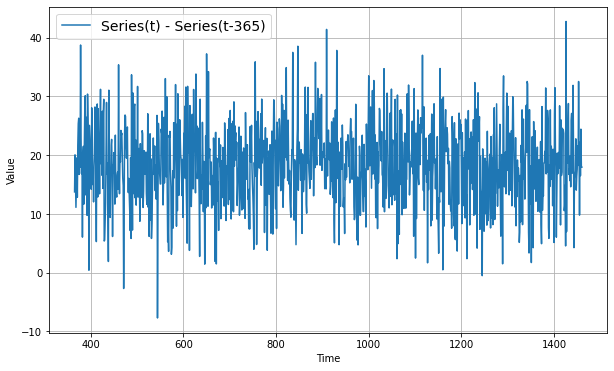

In [ ]:
diff_series = (series[365:] - series[:-365])
diff_time = time[365:]

plt.figure(figsize = (10,6))
plot_series(diff_time, diff_series, label = 'Series(t) - Series(t-365)')
plt.show()

### If we zoom in to the validation period, the difference time series looks, like Noise since we took out the rend and seasonality.

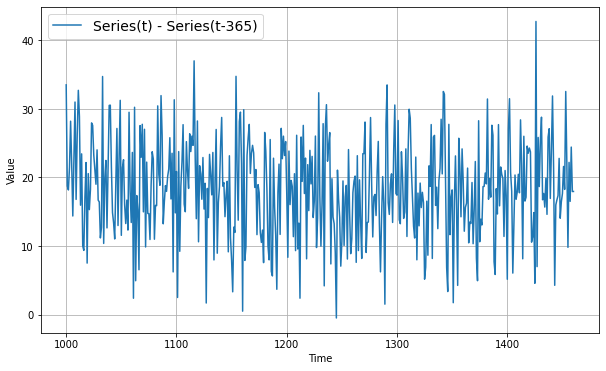

In [ ]:
plt.figure(figsize = (10,6))
plot_series(time_valid, diff_series[split_time- 365:], label = 'Series(t) - Series(t-365)')
plt.show()

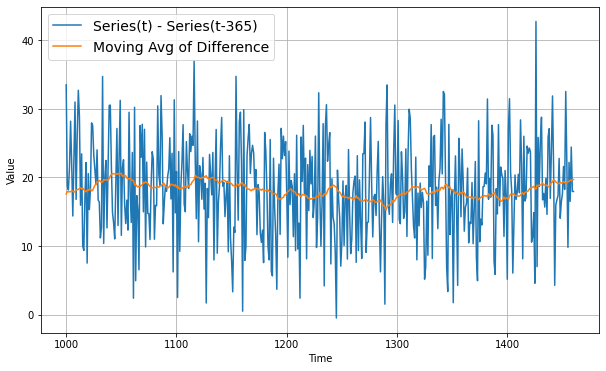

In [ ]:
win_size = 50
diff_moving_avg = moving_average_forecast(diff_series, win_size)[split_time -win_size-365:]

plt.figure(figsize = (10,6))
plot_series(time_valid, diff_series[split_time - 365:], label = "Series(t) - Series(t-365)")
plot_series(time_valid, diff_moving_avg, label = 'Moving Avg of Difference')


### Now, lets add back this difference moving avaerage to the original series and see what happens.

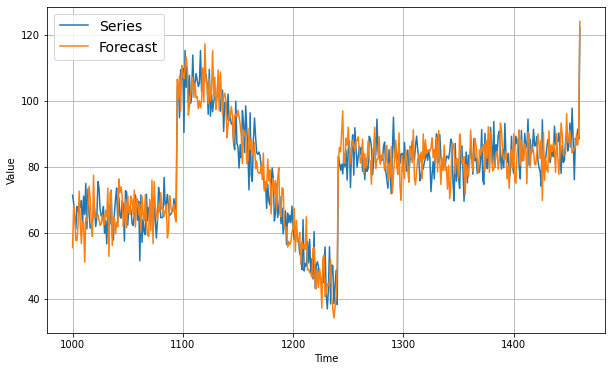

5.8393105629958955

In [ ]:
diff_moving_avg_plus_past = series[split_time - 365: -365] + diff_moving_avg

plt.figure(figsize = (10,6))
 
plot_series(time_valid, x_valid, label = "Series")
plot_series(time_valid, diff_moving_avg_plus_past, label = 'Forecast')
plt.show()

keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy()


Better than Naive Forecasting, good. However the forecasts look a bit too random, because we just added past values which were noisy. Lets use a moving average on the past values to remove some of the noise.

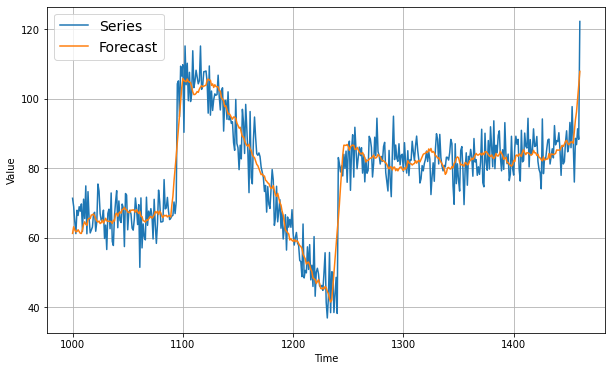

4.566859958970772

In [ ]:
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - 370: -359], 11) + diff_moving_avg

plt.figure(figsize = (10,6))
 
plot_series(time_valid, x_valid, label = "Series")
plot_series(time_valid, diff_moving_avg_plus_smooth_past, label = 'Forecast')
plt.show()

keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy()

This looks pretty good, anticipating the trend and seasonality well and with the mean absolute error at the minimum.

Lets now try Machine Learning. We will start with a simple model with just one Dense layer of one Neuron. This is a simple Regression model.

We will use Huber() loss function for training our regression model, which is quadratic for small errors and linear for large errors.

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 30))
optimizer = keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history_lr = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
31/31 [==============================] - 3s 5ms/step - loss: 67.6867 - mae: 68.1863
Epoch 2/100
31/31 [==============================] - 0s 5ms/step - loss: 52.3572 - mae: 52.8561
Epoch 3/100
31/31 [==============================] - 0s 4ms/step - loss: 34.6465 - mae: 35.1446
Epoch 4/100
31/31 [==============================] - 0s 3ms/step - loss: 17.6521 - mae: 18.1484
Epoch 5/100
31/31 [==============================] - 0s 4ms/step - loss: 8.4604 - mae: 8.9488
Epoch 6/100
31/31 [==============================] - 0s 4ms/step - loss: 7.9765 - mae: 8.4627
Epoch 7/100
31/31 [==============================] - 0s 4ms/step - loss: 7.9201 - mae: 8.4035
Epoch 8/100
31/31 [==============================] - 0s 4ms/step - loss: 7.8785 - mae: 8.3609
Epoch 9/100
31/31 [==============================] - 0s 4ms/step - loss: 7.8191 - mae: 8.3014
Epoch 10/100
31/31 [==============================] - 0s 4ms/step - loss: 7.7701 - mae: 8.2547
Epoch 11/100
31/31 [==============================]

(1e-06, 0.001, 0.0, 20.0)

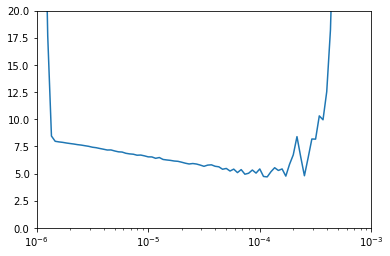

In [ ]:
plt.semilogx(history_lr.history["lr"], history_lr.history["loss"])
plt.axis([1e-6, 1e-3, 0, 20])


In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
history = model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/500
31/31 [==============================] - 1s 14ms/step - loss: 46.6813 - mae: 47.1784 - val_loss: 23.1475 - val_mae: 23.6473
Epoch 2/500
31/31 [==============================] - 0s 8ms/step - loss: 11.9123 - mae: 12.4017 - val_loss: 10.6108 - val_mae: 11.0934
Epoch 3/500
31/31 [==============================] - 0s 9ms/step - loss: 10.2063 - mae: 10.6947 - val_loss: 9.1115 - val_mae: 9.6013
Epoch 4/500
31/31 [==============================] - 0s 8ms/step - loss: 9.8053 - mae: 10.2898 - val_loss: 9.0103 - val_mae: 9.4965
Epoch 5/500
31/31 [==============================] - 0s 9ms/step - loss: 9.7068 - mae: 10.1940 - val_loss: 8.9696 - val_mae: 9.4569
Epoch 6/500
31/31 [==============================] - 0s 9ms/step - loss: 9.5858 - mae: 10.0706 - val_loss: 9.2814 - val_mae: 9.7695
Epoch 7/500
31/31 [==============================] - 0s 10ms/step - loss: 9.5716 - mae: 10.0561 - val_loss: 8.7506 - val_mae: 9.2409
Epoch 8/500
31/31 [==============================] - 0s 8ms/step - 

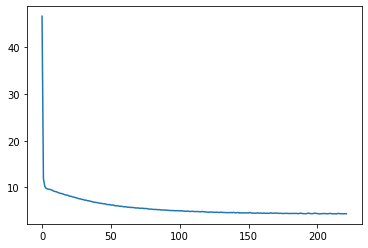

In [ ]:
plt.plot(range(222), history.history['loss'])
plt.show()

In [ ]:
lin_forecast = model_forecast(model, series[split_time - window_size:-1], window_size)[:, 0]


5.1662674

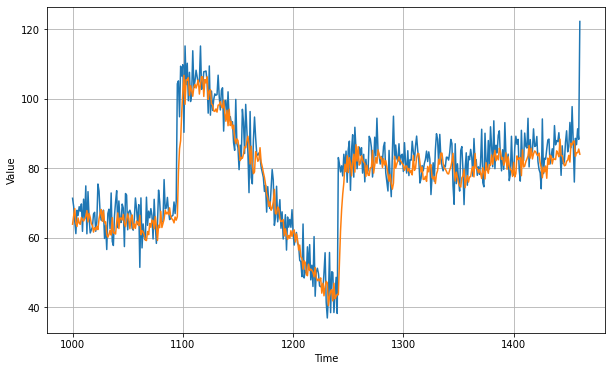

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, lin_forecast)

keras.metrics.mean_absolute_error(x_valid, lin_forecast).numpy()

## Dense Model Forecasting

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history_dense_lr = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 1s 4ms/step - loss: 43.8270 - mae: 44.3262
Epoch 2/100
31/31 [==============================] - 0s 4ms/step - loss: 41.5210 - mae: 42.0202
Epoch 3/100
31/31 [==============================] - 0s 4ms/step - loss: 38.6253 - mae: 39.1248
Epoch 4/100
31/31 [==============================] - 0s 4ms/step - loss: 35.3202 - mae: 35.8201
Epoch 5/100
31/31 [==============================] - 0s 4ms/step - loss: 31.5905 - mae: 32.0903
Epoch 6/100
31/31 [==============================] - 0s 4ms/step - loss: 27.4033 - mae: 27.9022
Epoch 7/100
31/31 [==============================] - 0s 4ms/step - loss: 22.7830 - mae: 23.2804
Epoch 8/100
31/31 [==============================] - 0s 4ms/step - loss: 17.7632 - mae: 18.2594
Epoch 9/100
31/31 [==============================] - 0s 4ms/step - loss: 12.6771 - mae: 13.1682
Epoch 10/100
31/31 [==============================] - 0s 4ms/step - loss: 8.5974 - mae: 9.0856
Epoch 11/100
31/31 [=====================

(1e-07, 0.005, 0.0, 30.0)

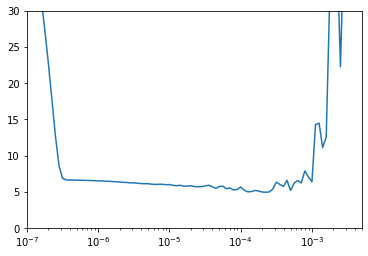

In [ ]:
plt.semilogx(history_dense_lr.history["lr"], history_dense_lr.history["loss"])
plt.axis([1e-7, 5e-3, 0, 30])

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

optimizer = keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
history_dense = model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
31/31 [==============================] - 1s 13ms/step - loss: 20.4049 - mae: 20.8986 - val_loss: 9.5125 - val_mae: 10.0037
Epoch 2/500
31/31 [==============================] - 0s 10ms/step - loss: 8.6179 - mae: 9.1027 - val_loss: 7.5804 - val_mae: 8.0585
Epoch 3/500
31/31 [==============================] - 0s 9ms/step - loss: 7.9849 - mae: 8.4702 - val_loss: 7.2411 - val_mae: 7.7189
Epoch 4/500
31/31 [==============================] - 0s 8ms/step - loss: 7.6780 - mae: 8.1603 - val_loss: 7.0971 - val_mae: 7.5798
Epoch 5/500
31/31 [==============================] - 0s 10ms/step - loss: 7.4285 - mae: 7.9136 - val_loss: 6.6877 - val_mae: 7.1663
Epoch 6/500
31/31 [==============================] - 0s 10ms/step - loss: 7.2165 - mae: 7.6989 - val_loss: 6.7449 - val_mae: 7.2319
Epoch 7/500
31/31 [==============================] - 0s 8ms/step - loss: 7.0491 - mae: 7.5318 - val_loss: 6.3436 - val_mae: 6.8156
Epoch 8/500
31/31 [==============================] - 0s 9ms/step - loss: 6.9

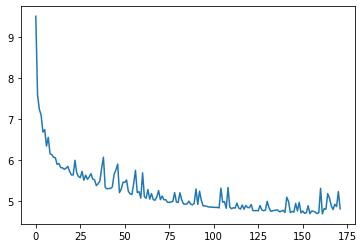

In [ ]:
#plt.plot(range(172), history_dense_earlystop.history['loss'])
plt.plot(range(172), history_dense.history['val_loss'])
plt.show()


In [ ]:
dense_forecast = model_forecast(
    model,
    series[split_time - window_size:-1],
    window_size)[:, 0]

5.2025537

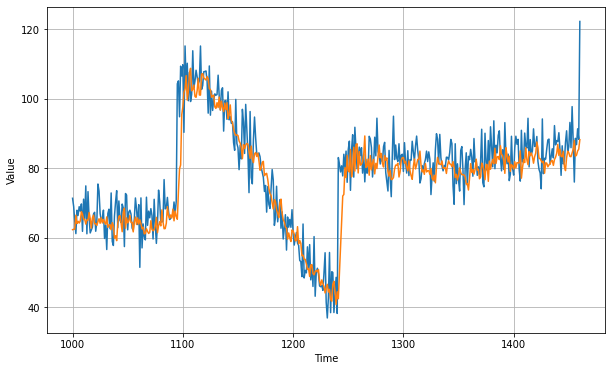

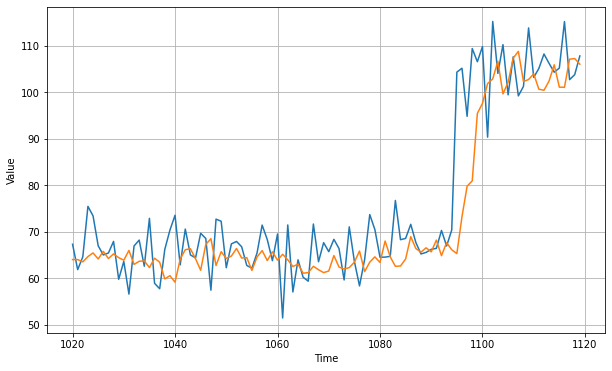

In [ ]:
plt.figure(figsize =(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, dense_forecast)

# Lets look at the zoomed in graph
plt.figure(figsize =(10,6))
plot_series(time_valid, x_valid, start=20, end= 120)  
plot_series(time_valid, dense_forecast , start=20, end= 120)


keras.metrics.mean_absolute_error(x_valid, dense_forecast).numpy()

## We tried Deep Neural network to predict the time series and saw the results. Its time to try the Recurrent Neural Networks (RNN) now and see how we can improve the results.

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size = 128)

model = keras.models.Sequential([
                                 keras.layers.Lambda(lambda x: tf.expand_dims(x, axis =-1), input_shape=[None]),
                                 keras.layers.SimpleRNN(100, return_sequences=True),
                                 keras.layers.SimpleRNN(100),
                                 keras.layers.Dense(1),
                                 keras.layers.Lambda(lambda x: x*200)
])

lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-07 * 10 ** (epoch/20))
optimizer = keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9)
model.compile(loss = keras.losses.Huber(), optimizer= optimizer, metrics = ['mae'])

history_rnn = model.fit(train_set, epochs =100, callbacks = [lr_schedule])

Epoch 1/100
8/8 [==============================] - 4s 75ms/step - loss: 50.2170 - mae: 50.7167
Epoch 2/100
8/8 [==============================] - 1s 73ms/step - loss: 23.0009 - mae: 23.4932
Epoch 3/100
8/8 [==============================] - 1s 69ms/step - loss: 19.2074 - mae: 19.7003
Epoch 4/100
8/8 [==============================] - 1s 68ms/step - loss: 16.9702 - mae: 17.4605
Epoch 5/100
8/8 [==============================] - 1s 70ms/step - loss: 15.4093 - mae: 15.8988
Epoch 6/100
8/8 [==============================] - 1s 67ms/step - loss: 14.7507 - mae: 15.2367
Epoch 7/100
8/8 [==============================] - 1s 65ms/step - loss: 14.3058 - mae: 14.7931
Epoch 8/100
8/8 [==============================] - 1s 74ms/step - loss: 14.0615 - mae: 14.5512
Epoch 9/100
8/8 [==============================] - 1s 69ms/step - loss: 13.7812 - mae: 14.2687
Epoch 10/100
8/8 [==============================] - 1s 70ms/step - loss: 13.5641 - mae: 14.0522
Epoch 11/100
8/8 [==============================]

(1e-07, 1e-05, 0.0, 40.0)

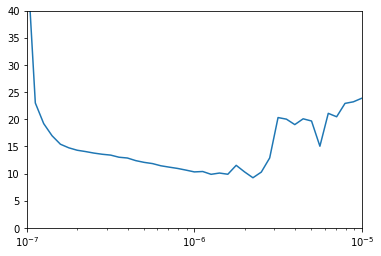

In [ ]:
plt.semilogx(history_rnn.history["lr"], history_rnn.history["loss"])
plt.axis([1e-7, 1e-5, 0, 40])

### Now that we know the optimal Learning Rate to be used from the graph above, we will retran the model using a learning rate of 1.5e-6 and we will use early stopping.

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size = 128)
valid_set = window_dataset(x_valid, window_size, batch_size=128)
model = keras.models.Sequential([
                                 keras.layers.Lambda(lambda x: tf.expand_dims(x, axis =-1), input_shape=[None]),
                                 keras.layers.SimpleRNN(100, return_sequences=True),
                                 keras.layers.SimpleRNN(100),
                                 keras.layers.Dense(1),
                                 keras.layers.Lambda(lambda x: x*200)
])

#lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-07 * 10 ** (epoch/20))
optimizer = keras.optimizers.SGD(learning_rate=1.5e-6, momentum=0.9)
model.compile(loss = keras.losses.Huber(), 
              optimizer= optimizer, 
              metrics = ['mae'])

early_stopping = keras.callbacks.EarlyStopping(patience=50)
model_checkpoint = keras.callbacks.ModelCheckpoint("my_checkpoint.h5", save_best_only=True)
history_rnn = model.fit(train_set, epochs =500, validation_data= valid_set, callbacks = [early_stopping, model_checkpoint])

Epoch 1/500
8/8 [==============================] - 3s 135ms/step - loss: 54.8861 - mae: 55.3847 - val_loss: 53.7722 - val_mae: 54.2722
Epoch 2/500
8/8 [==============================] - 1s 93ms/step - loss: 35.4594 - mae: 35.9563 - val_loss: 17.5197 - val_mae: 18.0159
Epoch 3/500
8/8 [==============================] - 1s 88ms/step - loss: 22.5446 - mae: 23.0387 - val_loss: 18.8162 - val_mae: 19.3131
Epoch 4/500
8/8 [==============================] - 1s 93ms/step - loss: 16.2157 - mae: 16.7055 - val_loss: 20.0789 - val_mae: 20.5776
Epoch 5/500
8/8 [==============================] - 1s 90ms/step - loss: 13.7456 - mae: 14.2346 - val_loss: 6.8457 - val_mae: 7.3288
Epoch 6/500
8/8 [==============================] - 1s 94ms/step - loss: 11.3548 - mae: 11.8351 - val_loss: 7.2709 - val_mae: 7.7557
Epoch 7/500
8/8 [==============================] - 1s 91ms/step - loss: 10.7631 - mae: 11.2440 - val_loss: 11.2749 - val_mae: 11.7682
Epoch 8/500
8/8 [==============================] - 1s 93ms/step -

In [ ]:
model = keras.models.load_model('my_checkpoint.h5')
rnn_forecast = model_forecast(model, series[split_time-window_size:-1], window_size)[:,0]

5.3282256

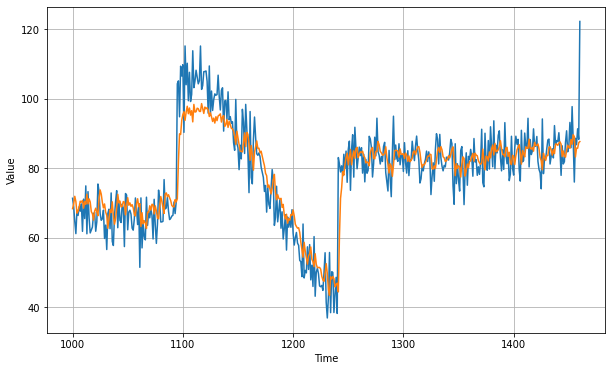

In [ ]:
plt.figure(figsize = (10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

### Our simple RNN here is not doing a great job. Its not able to do good over the changing patterns. It might be able to perform good if we preprocess the input data a little more.

Our next option is to try a Sequence to Sequence RNN model.

We will slightly update the Window_Dataset method for our sequence to sequence model. Instead of returning a label sequence of length 1, it will return a label sequence of the length equal to the window size. 

In [ ]:
for x_batch, y_batch in seq2seq_window_dataset(tf.range(10), 3, batch_size=1):
  print('x: ',  x_batch.numpy())
  print('y: ' , y_batch.numpy())

x:  [[[0]
  [1]
  [2]]]
y:  [[[1]
  [2]
  [3]]]


In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size, batch_size = 128)

model = keras.models.Sequential([                                
                                 keras.layers.SimpleRNN(100, return_sequences=True),
                                 keras.layers.SimpleRNN(100, return_sequences=True),
                                 keras.layers.Dense(1),
                                 keras.layers.Lambda(lambda x: x*200)
])

lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-07 * 10 ** (epoch/30))
optimizer = keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9)
model.compile(loss = keras.losses.Huber(), optimizer= optimizer, metrics = ['mae'])

history_s2s = model.fit(train_set, epochs =100, callbacks = [lr_schedule])

Epoch 1/100
8/8 [==============================] - 2s 78ms/step - loss: 52.3615 - mae: 52.8611
Epoch 2/100
8/8 [==============================] - 1s 72ms/step - loss: 25.4713 - mae: 25.9671
Epoch 3/100
8/8 [==============================] - 1s 73ms/step - loss: 23.5029 - mae: 23.9971
Epoch 4/100
8/8 [==============================] - 1s 72ms/step - loss: 21.1367 - mae: 21.6294
Epoch 5/100
8/8 [==============================] - 1s 70ms/step - loss: 19.4762 - mae: 19.9674
Epoch 6/100
8/8 [==============================] - 1s 71ms/step - loss: 18.6742 - mae: 19.1647
Epoch 7/100
8/8 [==============================] - 1s 71ms/step - loss: 18.1698 - mae: 18.6587
Epoch 8/100
8/8 [==============================] - 1s 71ms/step - loss: 17.7679 - mae: 18.2568
Epoch 9/100
8/8 [==============================] - 1s 73ms/step - loss: 17.4389 - mae: 17.9280
Epoch 10/100
8/8 [==============================] - 1s 83ms/step - loss: 17.0989 - mae: 17.5875
Epoch 11/100
8/8 [==============================]

(1e-07, 1e-05, 0.0, 30.0)

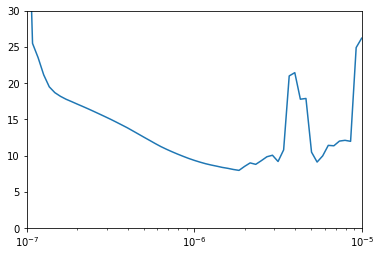

In [ ]:
plt.semilogx(history_s2s.history["lr"], history_s2s.history["loss"])
plt.axis([1e-7, 1e-5, 0, 30])

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size, batch_size = 128)
valid_set = seq2seq_window_dataset(x_valid, window_size, batch_size = 128)


model = keras.models.Sequential([                                
                                 keras.layers.SimpleRNN(100, return_sequences=True),
                                 keras.layers.SimpleRNN(100, return_sequences=True),
                                 keras.layers.Dense(1),
                                 keras.layers.Lambda(lambda x: x*200)
])

#lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-07 * 10 ** (epoch/30))
early_stopping = keras.callbacks.EarlyStopping(patience=15)
optimizer = keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)
model.compile(loss = keras.losses.Huber(), optimizer= optimizer, metrics = ['mae'])

history_s2s = model.fit(train_set, epochs =200, validation_data= valid_set,callbacks = [early_stopping])

Epoch 1/200
8/8 [==============================] - 3s 137ms/step - loss: 54.1430 - mae: 54.6414 - val_loss: 17.9208 - val_mae: 18.4156
Epoch 2/200
8/8 [==============================] - 1s 91ms/step - loss: 34.1722 - mae: 34.6695 - val_loss: 20.5483 - val_mae: 21.0442
Epoch 3/200
8/8 [==============================] - 1s 94ms/step - loss: 27.5074 - mae: 28.0027 - val_loss: 37.8715 - val_mae: 38.3709
Epoch 4/200
8/8 [==============================] - 1s 96ms/step - loss: 21.0647 - mae: 21.5579 - val_loss: 25.2686 - val_mae: 25.7675
Epoch 5/200
8/8 [==============================] - 1s 90ms/step - loss: 17.1768 - mae: 17.6667 - val_loss: 15.3557 - val_mae: 15.8506
Epoch 6/200
8/8 [==============================] - 1s 93ms/step - loss: 15.0383 - mae: 15.5247 - val_loss: 9.4218 - val_mae: 9.9071
Epoch 7/200
8/8 [==============================] - 1s 88ms/step - loss: 13.9508 - mae: 14.4372 - val_loss: 9.1617 - val_mae: 9.6474
Epoch 8/200
8/8 [==============================] - 1s 89ms/step -

In [ ]:
seq2seq_froecast = model_forecast(model, series[..., np.newaxis], window_size)
seq2seq_froecast = seq2seq_froecast[split_time - window_size:-1, -1, 0]

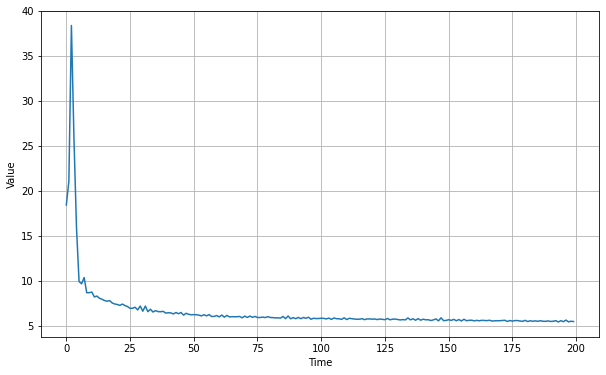

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(range(200), history_s2s.history['val_mae'])

5.3282256

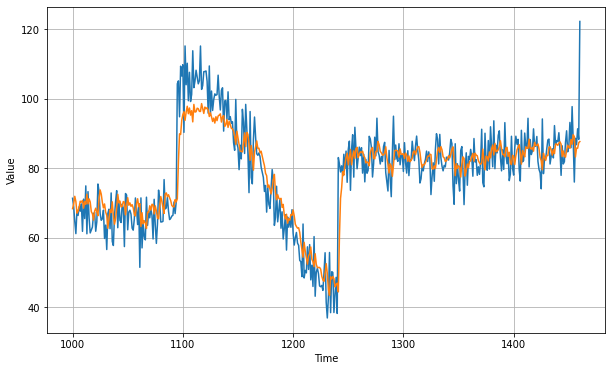

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

### This was a stateless RNN, we will now try a stateful RNN. 

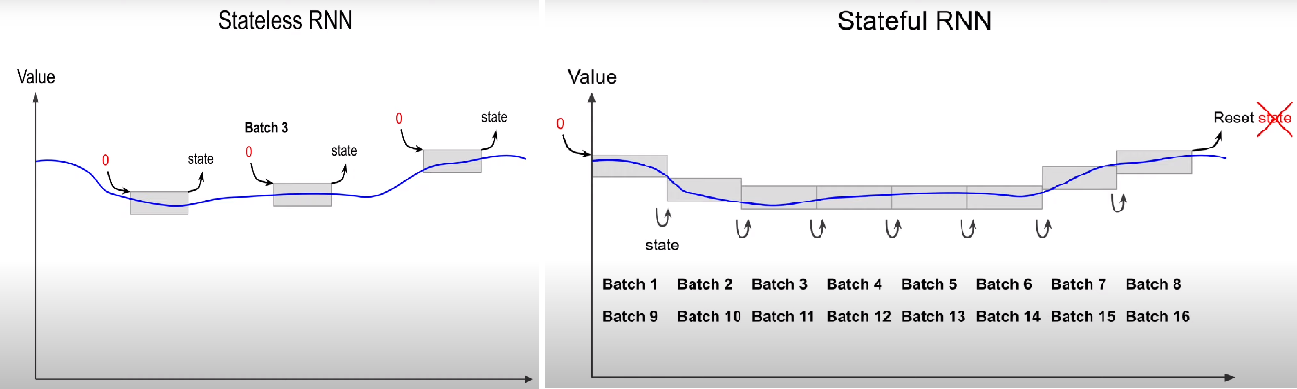